In [5]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, precision_recall_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from google.colab import files

In [7]:
df = pd.read_csv("/content/loan_data_clean.csv")
X = df.drop(columns=["loan_status"])
y = df["loan_status"].astype(int)

In [8]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print("Data loading complete")
print(f"Training set:{X_train.shape}|Test set:{X_test.shape}")


Data loading complete
Training set:(36000, 24)|Test set:(9000, 24)


In [ ]:
train_df = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
train_df.to_csv("/content/loan_train.csv", index=False)
files.download("/content/loan_train.csv")
print(f" Training set exported and downloaded: {train_df.shape}")
print(f"  Filename: loan_train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Training set exported and downloaded: (36000, 25)
  Filename: loan_train.csv


In [ ]:
test_df = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
test_df.to_csv("/content/loan_test.csv", index=False)
files.download("/content/loan_test.csv")
print(f"Test set exported and downloaded: {test_df.shape}")
print(f"  Filename: loan_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test set exported and downloaded: (9000, 25)
  Filename: loan_test.csv


In [46]:
cw=class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict=dict(zip(np.unique(y_train), cw))
scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]

In [47]:
key_feat = "previous_loan_defaults_on_file"
X_train_drop = X_train.drop(columns=[key_feat])
X_test_drop=X_test.drop(columns=[key_feat])
print(f"Removed feature:{key_feat}")
print(f"New feature count: {X_train_drop.shape[1]}")

Removed feature:previous_loan_defaults_on_file
New feature count: 23


In [48]:
xgb_base=XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,)

In [49]:
param_dist = {
    "n_estimators":[400, 600, 800],
    "max_depth":[3, 4, 5],
    "learning_rate":[0.03, 0.05, 0.08],
    "subsample":[0.7, 0.85, 1.0],
    "colsample_bytree":[0.6, 0.75, 0.9],
    "min_child_weight":[3, 5, 8],
    "gamma":[0, 0.1, 0.2],
    "reg_alpha":[0, 0.3, 0.6],
    "reg_lambda":[0.8, 1.0, 1.5],}

In [50]:
rf_params = {
    "n_estimators":[200,300,400],
    "max_depth":[10,15,20],
    "min_samples_split":[5,10,15],
    "min_samples_leaf":[2,4,6],
    "max_features":["sqrt","log2"],}

In [51]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [16]:
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [17]:
search.fit(X_train_drop, y_train)
model = search.best_estimator_

print(f"\n Best parameters: {search.best_params_}")
print(f" CV AUC: {search.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best parameters: {'subsample': 0.85, 'reg_lambda': 0.8, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 0.2, 'colsample_bytree': 0.6}
 CV AUC: 0.9355


In [18]:
rf_base = RandomForestClassifier(
    random_state=42, n_jobs=-1, class_weight="balanced"
)

search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_params,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [19]:
search_rf.fit(X_train_drop, y_train)
model_rf = search_rf.best_estimator_

print(f"\n Random Forest Best params: {search_rf.best_params_}")
print(f" Random Forest CV AUC: {search_rf.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Random Forest Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
 Random Forest CV AUC: 0.9210


In [52]:
proba=model.predict_proba(X_test_drop)[:,1]
proba_rf=model_rf.predict_proba(X_test_drop)[:,1]

In [53]:
precisions,recalls,thresholds=precision_recall_curve(y_test, proba)
precisions_cut=precisions[:-1]
recalls_cut=recalls[:-1]
f1_array=2 * precisions_cut * recalls_cut / (precisions_cut + recalls_cut + 1e-9)
best_f1_idx=np.argmax(f1_array)
best_thr=thresholds[best_f1_idx] if len(thresholds) > 0 else 0.5
pred_05=(proba >= 0.5).astype(int)
pred_opt=(proba >= best_thr).astype(int)
print(f"Best threshold:{best_thr:.3f}")

Best threshold:0.647


In [54]:
precisions_rf,recalls_rf,thresholds_rf=precision_recall_curve(y_test,proba_rf)
precisions_rf_cut=precisions_rf[:-1]
recalls_rf_cut=recalls_rf[:-1]
f1_array_rf=2 * precisions_rf_cut * recalls_rf_cut / (precisions_rf_cut + recalls_rf_cut + 1e-9)
best_f1_idx_rf=np.argmax(f1_array_rf)
best_thr_rf=thresholds_rf[best_f1_idx_rf] if len(thresholds_rf) > 0 else 0.5
pred_rf_05=(proba_rf >= 0.5).astype(int)
pred_rf_opt=(proba_rf >= best_thr_rf).astype(int)
print(f"Best threshold XGBoost:{best_thr:.3f}")
print(f"Best threshold RF:{best_thr_rf:.3f}")

Best threshold XGBoost:0.647
Best threshold RF:0.420


In [55]:
auc_score=roc_auc_score(y_test,proba)
acc_05=accuracy_score(y_test,pred_05)
prec_05=precision_score(y_test,pred_05)
rec_05=recall_score(y_test,pred_05)
f1_05=f1_score(y_test,pred_05)


In [56]:
acc_opt=accuracy_score(y_test,pred_opt)
prec_opt=precision_score(y_test,pred_opt)
rec_opt=recall_score(y_test,pred_opt)
f1_opt=f1_score(y_test,pred_opt)

In [25]:
auc_rf = roc_auc_score(y_test, proba_rf)
acc_rf_05 = accuracy_score(y_test, pred_rf_05)
prec_rf_05 = precision_score(y_test, pred_rf_05)
rec_rf_05 = recall_score(y_test, pred_rf_05)
f1_rf_05 = f1_score(y_test, pred_rf_05)


In [57]:
acc_rf_opt=accuracy_score(y_test,pred_rf_opt)
prec_rf_opt=precision_score(y_test,pred_rf_opt)
rec_rf_opt=recall_score(y_test,pred_rf_opt)
f1_rf_opt=f1_score(y_test,pred_rf_opt)

In [58]:
cm_05=confusion_matrix(y_test,pred_05)
cm_opt=confusion_matrix(y_test,pred_opt)
print(f"\n[XGBoost]")
print(f"[Threshold=0.5] AUC={auc_score:.4f} | ACC={acc_05:.4f} | PREC={prec_05:.4f} | REC={rec_05:.4f} | F1={f1_05:.4f}")
print(f"[Threshold={best_thr:.3f}] ACC={acc_opt:.4f} | PREC={prec_opt:.4f} | REC={rec_opt:.4f} | F1={f1_opt:.4f}")
print(f"\n[Random Forest]")
print(f"[Threshold=0.5] AUC={auc_rf:.4f} | ACC={acc_rf_05:.4f} | PREC={prec_rf_05:.4f} | REC={rec_rf_05:.4f} | F1={f1_rf_05:.4f}")
print(f"[Threshold={best_thr_rf:.3f}] ACC={acc_rf_opt:.4f} | PREC={prec_rf_opt:.4f} | REC={rec_rf_opt:.4f} | F1={f1_rf_opt:.4f}")


[XGBoost]
[Threshold=0.5] AUC=0.9393 | ACC=0.8904 | PREC=0.7302 | REC=0.8040 | F1=0.7653
[Threshold=0.647] ACC=0.9150 | PREC=0.8617 | REC=0.7355 | F1=0.7936

[Random Forest]
[Threshold=0.5] AUC=0.9258 | ACC=0.9054 | PREC=0.8606 | REC=0.6855 | F1=0.7632
[Threshold=0.420] ACC=0.9020 | PREC=0.8102 | REC=0.7300 | F1=0.7680


In [59]:
metrics_dict = {
    "XGBoost": {
        "AUC": auc_score,
        "Accuracy": acc_opt,
        "Precision": prec_opt,
        "Recall": rec_opt,
        "F1-Score": f1_opt
    },
    "Random Forest": {
        "AUC": auc_rf,
        "Accuracy": acc_rf_opt,
        "Precision": prec_rf_opt,
        "Recall": rec_rf_opt,
        "F1-Score": f1_rf_opt
    }
}
metrics_df = pd.DataFrame(metrics_dict).T
print("\n Model performance comparison:")
print(metrics_df.round(4))


 Model performance comparison:
                  AUC  Accuracy  Precision  Recall  F1-Score
XGBoost        0.9393     0.915     0.8617  0.7355    0.7936
Random Forest  0.9258     0.902     0.8102  0.7300    0.7680


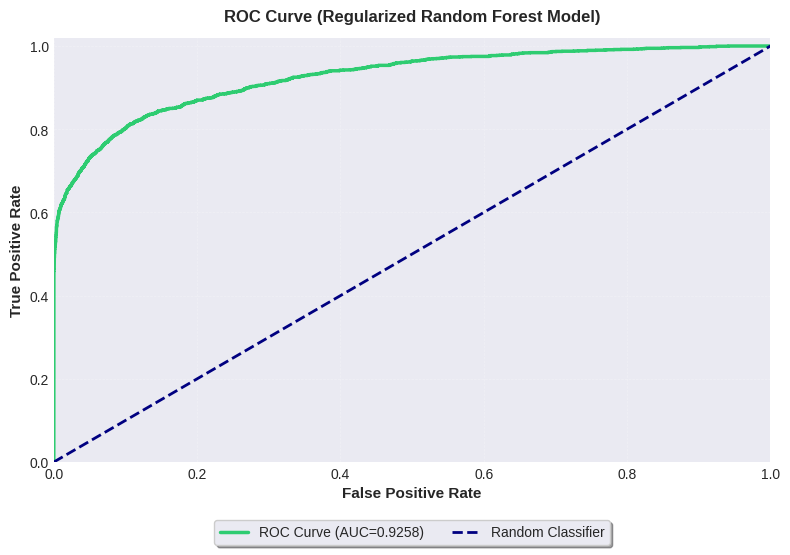

In [60]:
fpr_rf,tpr_rf,_=roc_curve(y_test,proba_rf)
roc_auc_rf=auc(fpr_rf,tpr_rf)
fig,ax=plt.subplots(figsize=(8,6))

ax.plot(fpr_rf,tpr_rf,color='#2ecc71',lw=2.5,label=f'ROC Curve (AUC={roc_auc_rf:.4f})')
ax.plot([0,1],[0,1],color='navy',lw=2,linestyle='--', label='Random Classifier')

ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.02])
ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax.set_title('ROC Curve (Regularized Random Forest Model)',fontsize=12, fontweight='bold', pad=12)


ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.12),
          ncol=2,
          fontsize=10,
          frameon=True,
          shadow=True)

ax.grid(alpha=0.3,linestyle='--',linewidth=0.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)
plt.show()


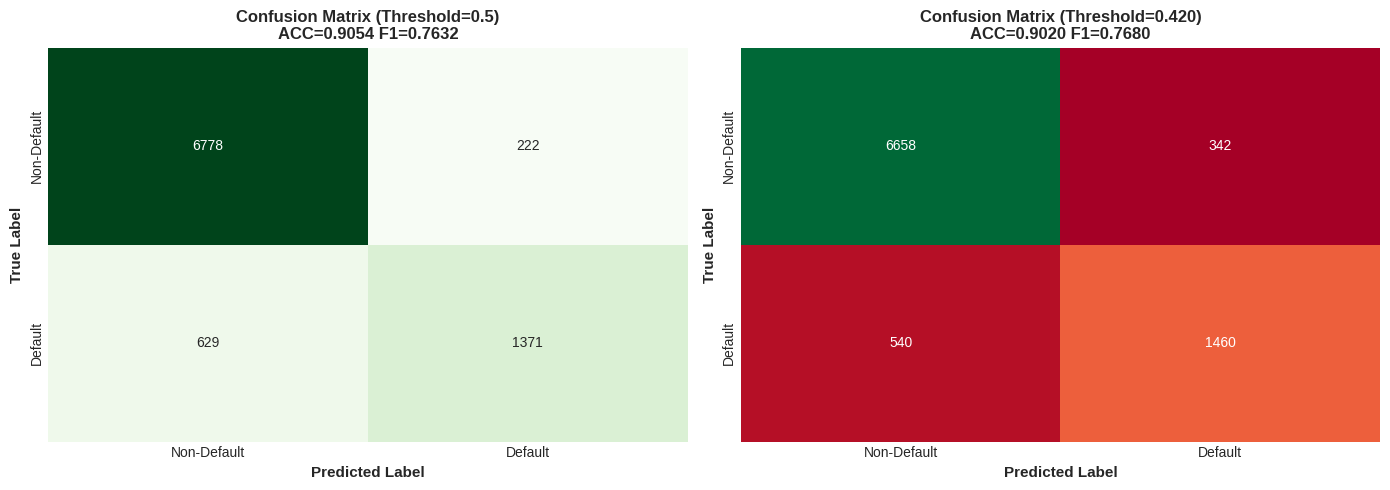

In [61]:
cm_rf_05=confusion_matrix(y_test,pred_rf_05)
cm_rf_opt=confusion_matrix(y_test,pred_rf_opt)

fig,axes=plt.subplots(1,2,figsize=(14,5))

sns.heatmap(cm_rf_05,annot=True,fmt='d',cmap='Greens',ax=axes[0],cbar=False,xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
axes[0].set_title(f'Confusion Matrix (Threshold=0.5)\nACC={acc_rf_05:.4f} F1={f1_rf_05:.4f}',fontsize=12,fontweight='bold')
axes[0].set_ylabel('True Label',fontsize=11,fontweight='bold')
axes[0].set_xlabel('Predicted Label',fontsize=11,fontweight='bold')

sns.heatmap(cm_rf_opt,annot=True,fmt='d',cmap='RdYlGn',ax=axes[1],cbar=False,xticklabels=['Non-Default','Default'],yticklabels=['Non-Default','Default'])
axes[1].set_title(f'Confusion Matrix (Threshold={best_thr_rf:.3f})\nACC={acc_rf_opt:.4f} F1={f1_rf_opt:.4f}',fontsize=12,fontweight='bold')
axes[1].set_ylabel('True Label',fontsize=11,fontweight='bold')
axes[1].set_xlabel('Predicted Label',fontsize=11,fontweight='bold')
plt.tight_layout()
plt.show()

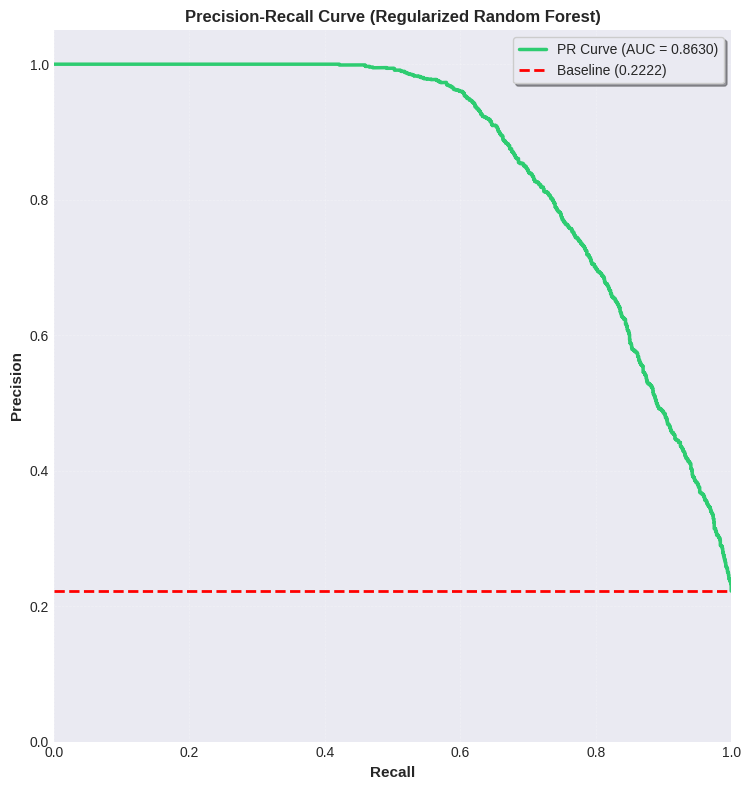

In [38]:
precisions_pr_rf,recalls_pr_rf,_=precision_recall_curve(y_test, proba_rf)
pr_auc_rf=auc(recalls_pr_rf,precisions_pr_rf)

fig,ax=plt.subplots(figsize=(10,8))
ax.plot(recalls_pr_rf,precisions_pr_rf,color='#2ecc71',lw=2.5,label=f'PR Curve (AUC={pr_auc_rf:.4f})')
ax.axhline(y=np.mean(y_test), color='red', lw=2, linestyle='--', label=f'Baseline ({np.mean(y_test):.4f})')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.05])
ax.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax.set_title('Precision-Recall Curve (Regularized Random Forest)', fontsize=12, fontweight='bold')
ax.legend(loc="best", fontsize=10, frameon=True, shadow=True)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

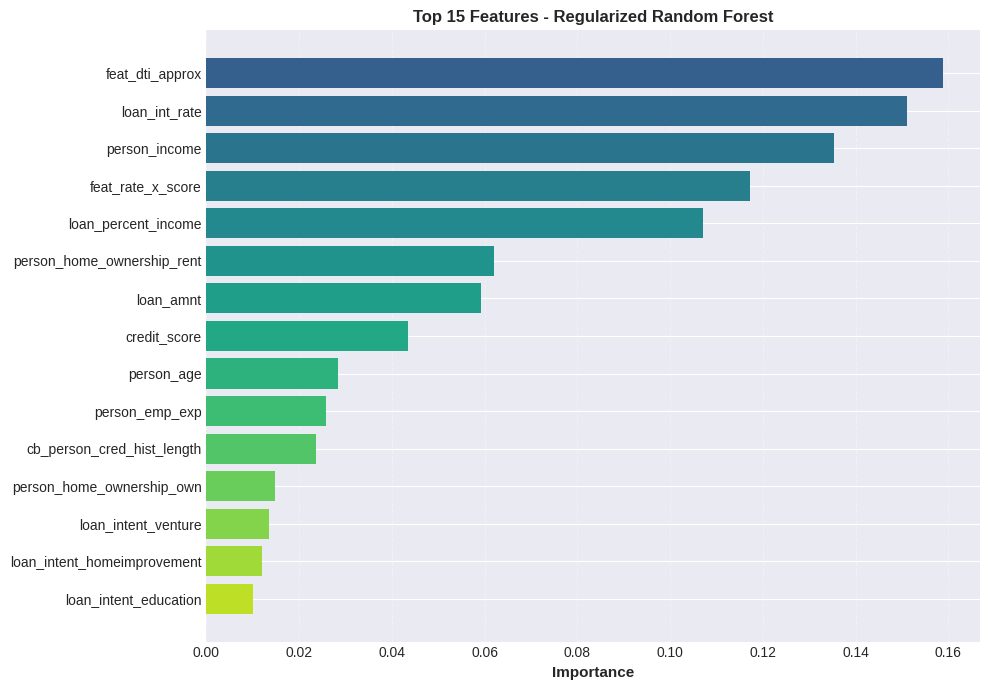

In [43]:
imp_rf = pd.DataFrame({
    "feature": X_test_drop.columns,
    "importance": model_rf.feature_importances_
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
top_n =15

colors =plt.cm.viridis(np.linspace(0.3,0.9,top_n))

ax.barh(range(top_n), imp_rf["importance"].head(top_n).values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(imp_rf["feature"].head(top_n).values,fontsize=10)
ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Regularized Random Forest', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x',alpha=0.3,linestyle='--')

plt.tight_layout()
plt.show()


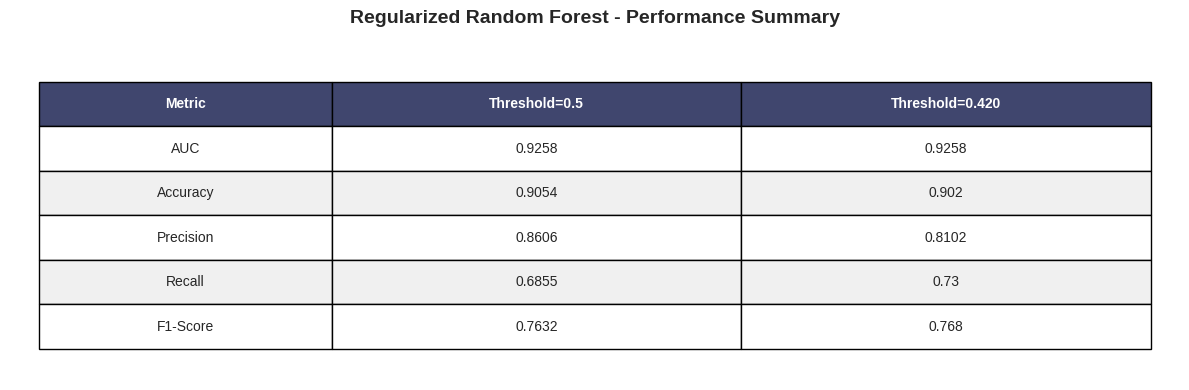

In [33]:
summary_rf_df = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1-Score"],
    "Threshold=0.5": [auc_rf, acc_rf_05, prec_rf_05, rec_rf_05, f1_rf_05],
    f"Threshold={best_thr_rf:.3f}": [auc_rf, acc_rf_opt, prec_rf_opt, rec_rf_opt, f1_rf_opt]
})

fig,ax=plt.subplots(figsize=(12,4))
ax.axis('off')

metrics_col = summary_rf_df["Metric"].values
numeric_data = summary_rf_df.iloc[:,1:].values.round(4)
table_data = np.column_stack([metrics_col,numeric_data])

table = ax.table(cellText=table_data,
                colLabels=summary_rf_df.columns,
                cellLoc='center', loc='center',
                colWidths=[0.25,0.35,0.35])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1,2.5)

for i in range(len(summary_rf_df.columns)):
    table[(0,i)].set_facecolor('#40466e')
    table[(0,i)].set_text_props(weight='bold',color='white')

for i in range(1,len(summary_rf_df) + 1):
    for j in range(len(summary_rf_df.columns)):
        table[(i,j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

plt.title('Regularized Random Forest - Performance Summary',fontsize=14,fontweight='bold',pad=20)
plt.tight_layout()
plt.show()